# Imports básicos para todas as análises

In [65]:
# Desativar as mensagens de 'warning' que ficam poluindo o output aqui no Colab

import warnings
warnings.filterwarnings("ignore")

In [66]:
import  pandas as pd,               \
        numpy as np,                \
        matplotlib.pyplot as plt,   \
        seaborn as sns


from matplotlib.pylab import rcParams
from pandas.plotting  import register_matplotlib_converters

from xgboost import XGBRegressor, plot_importance

from neuralforecast         import NeuralForecast
from neuralforecast.auto    import AutoLSTM, AutoNHITS
from neuralforecast.models  import LSTM, NHITS
from neuralforecast.losses.pytorch import DistributionLoss, SMAPE

from sklearn.metrics import r2_score, mean_squared_error

from sktime.utils.plotting import plot_series
#from sktime.forecasting.compose import make_reduction
#from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# Ajustes feitos para geração e criação de gráfico
sns.set_style('darkgrid')
# rcParams['figure.figsize'] = 15, 6
rcParams['figure.figsize'] = 20, 10

# Tratar conversões de DateTime entre o Pandas e o Matplotlib
register_matplotlib_converters()

# Symmetric Mean Absolute Percentage Error
smape = MeanAbsolutePercentageError(symmetric=True)

### Utilidades

In [67]:
# Retirado de: <https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/common/utils.py>

from collections import UserDict

class TimeSeriesStructure(UserDict):
    """
    Use this class to:
      1. Shift the values of the time series to create a Pandas dataframe containing all the data
         for a single training example
      2. Discard any samples with missing values
      3. Transform this Pandas dataframe into a numpy array of shape
         (samples, time steps, features) for input into Keras

    The class takes the following parameters:
       - **dataset**: original time series
       - **target** name of the target column
       - **H**: the forecast horizon
       - **tensor_structures**: a dictionary discribing the tensor structure of the form
             { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
             if features are non-sequential and should not be shifted, use the form
             { 'tensor_name' : (None, [feature, feature, ...])}
       - **freq**: time series frequency (default 'H' - hourly)
       - **drop_incomplete**: (Boolean) whether to drop incomplete samples (default True)
    """

    def __init__(self, dataset, target, H, tensor_structure, freq='H', drop_incomplete=True):
        self.dataset = dataset
        self.target = target
        self.tensor_structure = tensor_structure
        self.tensor_names = list(tensor_structure.keys())

        self.dataframe = self._shift_data(H, freq, drop_incomplete)
        self.data = self._df2tensors(self.dataframe)

    def _shift_data(self, H, freq, drop_incomplete):

        # Use the tensor_structures definitions to shift the features in the original dataset.
        # The result is a Pandas dataframe with multi-index columns in the hierarchy
        #     tensor - the name of the input tensor
        #     feature - the input feature to be shifted
        #     time step - the time step for the RNN in which the data is input. These labels
        #         are centred on time t. the forecast creation time
        df = self.dataset.copy()

        idx_tuples = []
        for t in range(1, H+1):
            df['t+'+str(t)] = df[self.target].shift(t*-1, freq=freq)
            idx_tuples.append(('target', 'y', 't+'+str(t)))

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            dataset_cols = structure[1]

            for col in dataset_cols:

            # do not shift non-sequential 'static' features
                if rng is None:
                    df['context_'+col] = df[col]
                    idx_tuples.append((name, col, 'static'))

                else:
                    for t in rng:
                        sign = '+' if t > 0 else ''
                        shift = str(t) if t != 0 else ''
                        period = 't'+sign+shift
                        shifted_col = name+'_'+col+'_'+period
                        df[shifted_col] = df[col].shift(t*-1, freq=freq)
                        idx_tuples.append((name, col, period))

        df = df.drop(self.dataset.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        df.columns = idx

        if drop_incomplete:
            df = df.dropna(how='any')

        return df

    def _df2tensors(self, dataframe):

        # Transform the shifted Pandas dataframe into the multidimensional numpy arrays. These
        # arrays can be used to input into the keras model and can be accessed by tensor name.
        # For example, for a TimeSeriesTensor object named "model_inputs" and a tensor named
        # "target", the input tensor can be acccessed with model_inputs['target']

        inputs = {}
        y = dataframe['target']
        y = y.values
        inputs['target'] = y

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            cols = structure[1]
            tensor = dataframe[name][cols].values
            if rng is None:
                tensor = tensor.reshape(tensor.shape[0], len(cols))
            else:
                tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
                tensor = np.transpose(tensor, axes=[0, 2, 1])
            inputs[name] = tensor

        return inputs

    def subset_data(self, new_dataframe):

        # Use this function to recreate the input tensors if the shifted dataframe
        # has been filtered.

        self.dataframe = new_dataframe
        self.data = self._df2tensors(self.dataframe)

In [68]:
class DataSet():
    
    def __init__(self, file, adjust=True):
        self.df = pd.read_csv(file, sep='\t', index_col=0, header=0, parse_dates=['ds'])

        if adjust:
            self.df = self.df.resample('D').first() # deixando a série contínua numa base diária
            self.df.fillna(self.df.mean(), inplace=True) # isso, possivelmente, criará lacunas com "NaN" e precisa executar este passo

        # Deixando ajustado para usar com as libs Nixtla
        self.df['unique_id'] = 1
        self.df.reset_index(inplace=True)

        # ==================================================================================== #
        # Estes atributos são para aplicação em Aprendizado Supervisionado (Machine Learning)
        # Também dá pra usar em Deep Learning com a lib Keras
        # self.ml_inputs = None # Este atributo receberá um objeto da classe "TimeSeriesStructure"       
        # self.ml_train = None
        # self.ml_validation = None
        # self.X = None
        # self.y = None
        # self.X_test = None
        # self.y_test = None
        # self.X_train = None
        # self.y_train = None
        # self.X_validation = None
        # self.y_validation = None
        # ==================================================================================== #
        # Usar estas estruturas com a lib Nixtla{NeuralForecast | MLForecast}        
        self.train = None
        self.test = None
        self.validation = None
        # ==================================================================================== #

    # O corte realizado por esse método é simples: pega do início da série até 'train_size' e coloca no DataFrame 'train'.
    # O que resta do corte é colocado no DataFrame 'validation'
    def split_train_test(self, dataframe, train_size=0.7):

        # Tamanho total da série
        size = dataframe.shape[0]

        # Tamanho do treino
        t_size = int(size * train_size)

        train = dataframe.iloc[0:t_size]
        validation = dataframe.iloc[t_size:]

        return train, validation

# Alto Doce

## Carregando os dados para análise

In [69]:
ds_alto = DataSet('alto_doce.csv')
ds_alto.df.describe()

,ds,y,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva4,vazao4,chuva5,vazao5,chuva6,vazao6,unique_id
count,3683,3683.000000,3683.00000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.0
mean,2018-01-16 00:00:00,120.963956,2.90080,69.662090,2.667560,71.762139,2.295398,28.032810,0.045096,254.083439,2.877480,115.548849,3.277873,61.976891,1.0
min,2013-01-01 00:00:00,17.410000,0.00000,9.791935,0.000000,0.000000,0.000000,0.000000,0.000000,190.820000,0.000000,21.340000,0.000000,10.058000,1.0
25%,2015-07-10 12:00:00,59.818000,0.00000,30.884896,0.000000,39.444375,0.000000,10.192120,0.000000,254.035853,0.000000,71.138043,0.000000,29.494000,1.0
50%,2018-01-16 00:00:00,85.107000,0.00000,52.265625,2.100000,71.762139,1.400000,28.032810,0.000000,254.035853,2.000000,115.548849,3.277873,45.371000,1.0
75%,2020-07-24 12:00:00,134.837000,0.40000,74.283958,2.667560,71.762139,2.295398,30.081330,0.045096,254.083439,2.877480,115.548849,3.277873,65.381000,1.0
max,2023-01-31 00:00:00,2000.467000,139.20000,806.008148,111.200000,949.781250,100.000000,261.545833,16.700000,377.050000,192.200000,1936.280000,172.400000,849.711000,1.0
std,NaN,123.811284,9.48174,65.914976,7.136782,59.072915,5.834512,28.915250,0.449132,2.527514,7.864615,110.591662,8.015500,60.153906,0.0


In [70]:
ds_alto.df

,ds,y,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva4,vazao4,chuva5,vazao5,chuva6,vazao6,unique_id
0,2013-01-01,82.787,0.0,49.475000,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,60.056000,1
1,2013-01-02,80.489,0.0,46.957143,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,37.546000,1
2,2013-01-03,78.214,0.0,46.721875,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,39.228000,1
3,2013-01-04,79.349,0.0,49.183333,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,37.546000,1
4,2013-01-05,129.161,0.0,49.780208,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,39.228000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,2023-01-27,648.940,0.8,388.402708,0.80000,369.873333,2.400000,120.202917,0.000000,311.915263,0.00000,565.199583,0.200000,61.976891,1
3679,2023-01-28,520.591,0.0,263.569896,0.00000,244.310833,0.000000,111.370833,0.000000,243.242500,2.60000,387.516250,0.000000,61.976891,1
3680,2023-01-29,424.853,0.0,242.208229,0.00000,216.592083,0.000000,93.840417,0.000000,190.820000,0.00000,321.508333,0.000000,61.976891,1
3681,2023-01-30,362.965,0.0,227.691875,0.00000,206.661667,0.200000,81.679167,0.000000,228.868824,0.00000,299.070417,0.000000,61.976891,1


## Análise exploratória dos dados

### Decomposição da Série Temporal da vazão 'y' (estação principal)

A decomposição da série temporal principal ('y'/'target') ajuda a detectar padrões e identificar outras informações que podem ajudar na interpretação do que está acontecendo

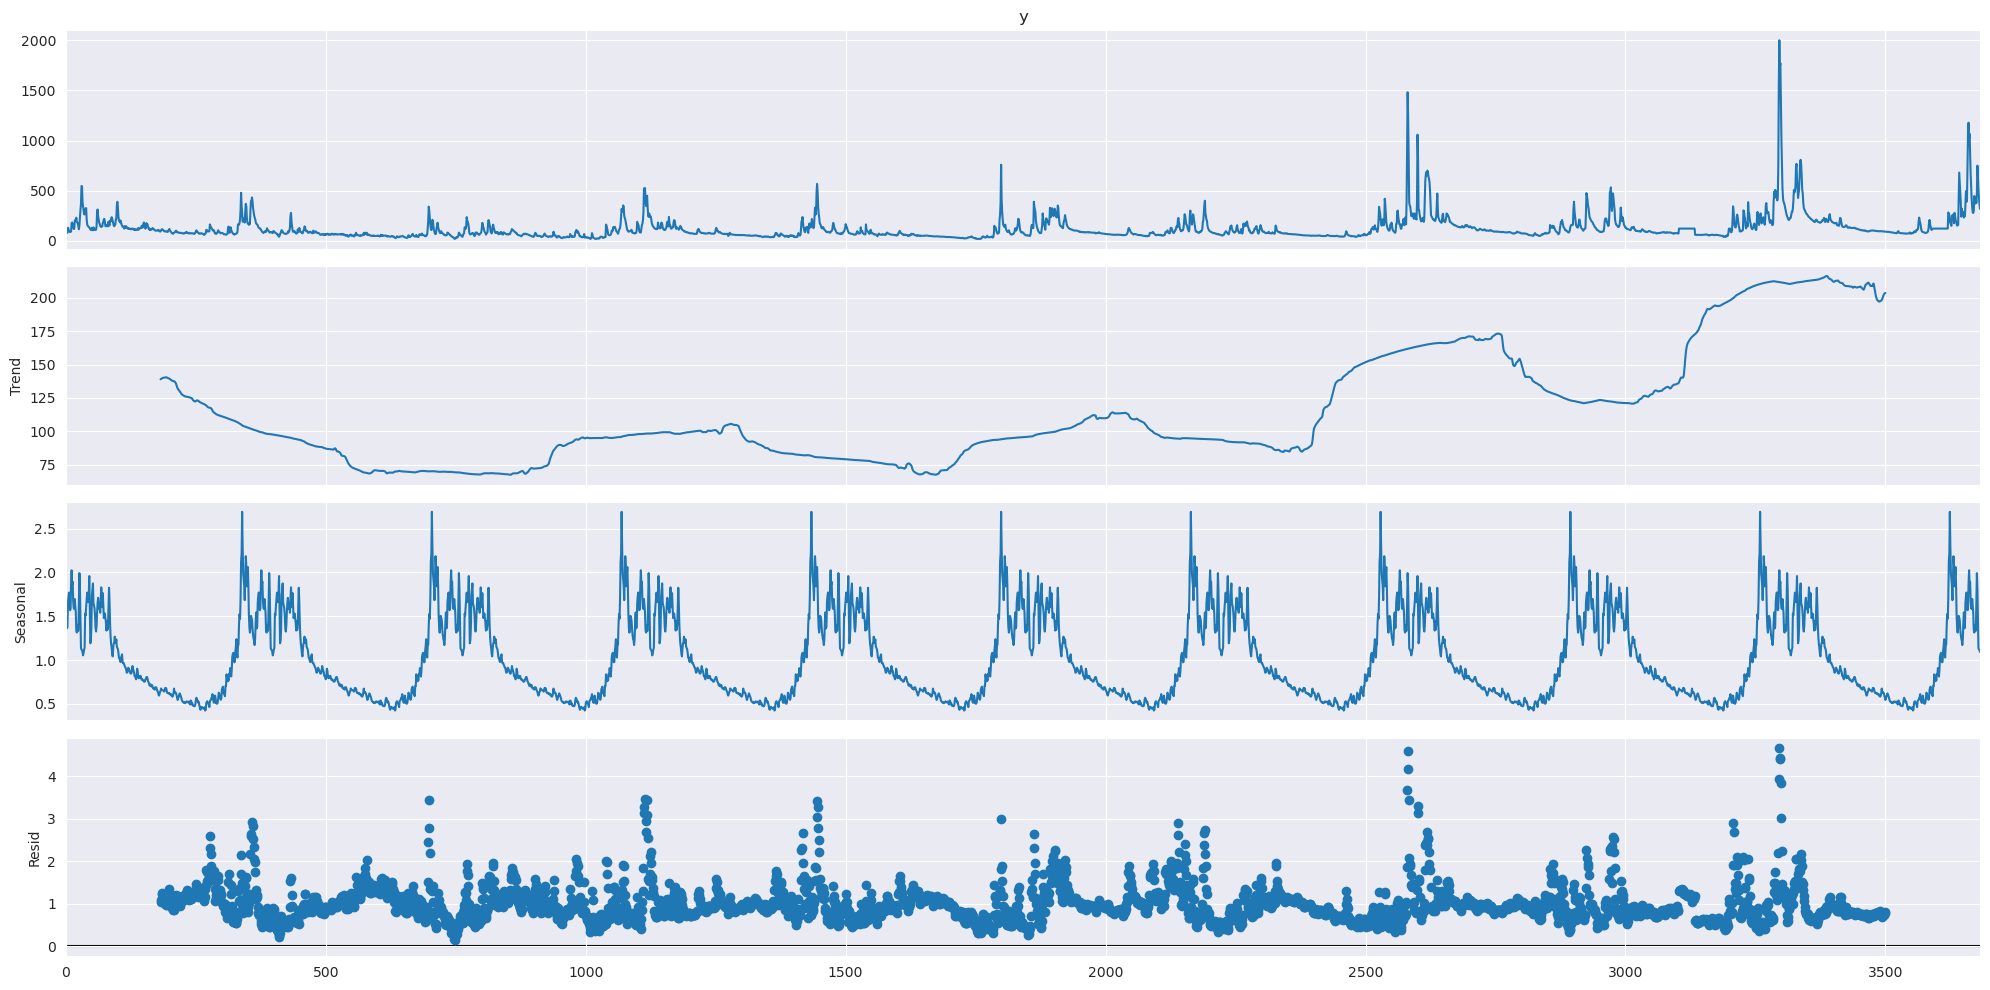

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose

vazao_y = seasonal_decompose(ds_alto.df['y'], period=365, model="mult")
vazao_y.plot() # este ';' é macetão pra não plotar duplicado este gráfico.
plt.show()

### Teste de estacionariedade da vazão 'y'

Novamente. Identificar informações, comportamento da Série Temporal em anaálise

In [72]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ds_alto.df['y'])

if result[1] <= 0.05:
    print("ESTACIONÁRIA")
else:
    print("NÃO ESTACIONÁRIA")

ESTACIONÁRIA


In [73]:
# Mapa de correlação do DataFrame
ds_alto.df.corr().style.background_gradient(cmap='coolwarm')

,ds,y,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva4,vazao4,chuva5,vazao5,chuva6,vazao6,unique_id
ds,1.000000,0.243995,0.073067,0.201175,0.000797,0.107683,0.029763,0.149207,-0.049045,0.010846,0.000585,0.128160,0.014403,0.181586,nan
y,0.243995,1.000000,0.268765,0.925556,0.268953,0.864723,0.246664,0.405192,-0.039812,0.069295,0.181228,0.886830,0.187818,0.845410,nan
chuva1,0.073067,0.268765,1.000000,0.270683,0.552330,0.225275,0.492518,0.205762,0.032928,-0.001726,0.390331,0.266706,0.399461,0.271507,nan
vazao1,0.201175,0.925556,0.270683,1.000000,0.238439,0.857252,0.225226,0.398863,-0.041772,0.084366,0.178644,0.844699,0.207285,0.870007,nan
chuva2,0.000797,0.268953,0.552330,0.238439,1.000000,0.246980,0.597748,0.268420,0.086183,-0.003044,0.532358,0.315741,0.403620,0.180795,nan
vazao2,0.107683,0.864723,0.225275,0.857252,0.246980,1.000000,0.202504,0.404864,-0.038198,0.090402,0.162788,0.928386,0.201542,0.753145,nan
chuva3,0.029763,0.246664,0.492518,0.225226,0.597748,0.202504,1.000000,0.264566,0.089278,-0.000904,0.519031,0.262896,0.293118,0.174690,nan
vazao3,0.149207,0.405192,0.205762,0.398863,0.268420,0.404864,0.264566,1.000000,-0.041096,0.046113,0.213777,0.405526,0.149993,0.306674,nan
chuva4,-0.049045,-0.039812,0.032928,-0.041772,0.086183,-0.038198,0.089278,-0.041096,1.000000,-0.001068,0.083350,-0.038392,0.029414,-0.041734,nan
vazao4,0.010846,0.069295,-0.001726,0.084366,-0.003044,0.090402,-0.000904,0.046113,-0.001068,1.000000,-0.001990,0.074197,-0.004194,-0.001247,nan


In [74]:
# Usando o sweetviz para avaliar
# import sweetviz as sv
# analyze_report = sv.analyze(ds_alto.df)
# analyze_report.show_html('analyze.html', open_browser=True)

# Apresentando os resultados
# import IPython
# IPython.display.HTML('analyze.html')

Após análise com ajuda do SweetViz, removi as colunas "chuva4" e "vazao4" porque, de tanta lacuna e preenchimento com média,<br/>
elas foram detectadas como categóricas e pouco tinham de relação com as demais informações.

In [75]:
ds_alto.df.drop(columns=["chuva4", "vazao4"], inplace=True)

In [76]:
# Mapa de correlação do DataFrame após remoção das colunas
ds_alto.df.corr().style.background_gradient(cmap='coolwarm')

,ds,y,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva5,vazao5,chuva6,vazao6,unique_id
ds,1.000000,0.243995,0.073067,0.201175,0.000797,0.107683,0.029763,0.149207,0.000585,0.128160,0.014403,0.181586,nan
y,0.243995,1.000000,0.268765,0.925556,0.268953,0.864723,0.246664,0.405192,0.181228,0.886830,0.187818,0.845410,nan
chuva1,0.073067,0.268765,1.000000,0.270683,0.552330,0.225275,0.492518,0.205762,0.390331,0.266706,0.399461,0.271507,nan
vazao1,0.201175,0.925556,0.270683,1.000000,0.238439,0.857252,0.225226,0.398863,0.178644,0.844699,0.207285,0.870007,nan
chuva2,0.000797,0.268953,0.552330,0.238439,1.000000,0.246980,0.597748,0.268420,0.532358,0.315741,0.403620,0.180795,nan
vazao2,0.107683,0.864723,0.225275,0.857252,0.246980,1.000000,0.202504,0.404864,0.162788,0.928386,0.201542,0.753145,nan
chuva3,0.029763,0.246664,0.492518,0.225226,0.597748,0.202504,1.000000,0.264566,0.519031,0.262896,0.293118,0.174690,nan
vazao3,0.149207,0.405192,0.205762,0.398863,0.268420,0.404864,0.264566,1.000000,0.213777,0.405526,0.149993,0.306674,nan
chuva5,0.000585,0.181228,0.390331,0.178644,0.532358,0.162788,0.519031,0.213777,1.000000,0.211561,0.287275,0.177663,nan
vazao5,0.128160,0.886830,0.266706,0.844699,0.315741,0.928386,0.262896,0.405526,0.211561,1.000000,0.222652,0.758893,nan


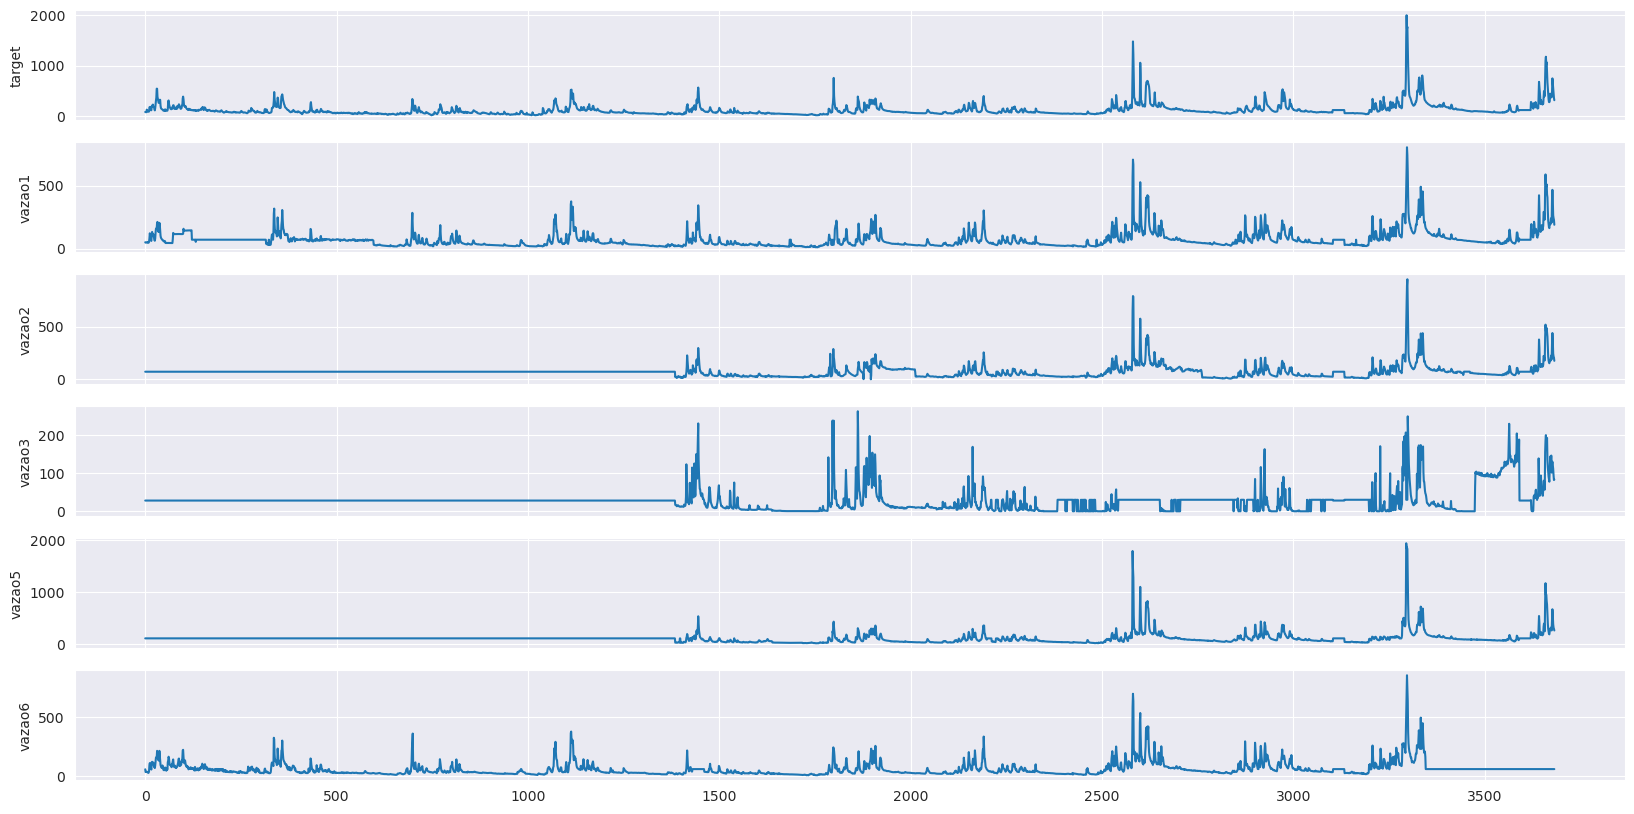

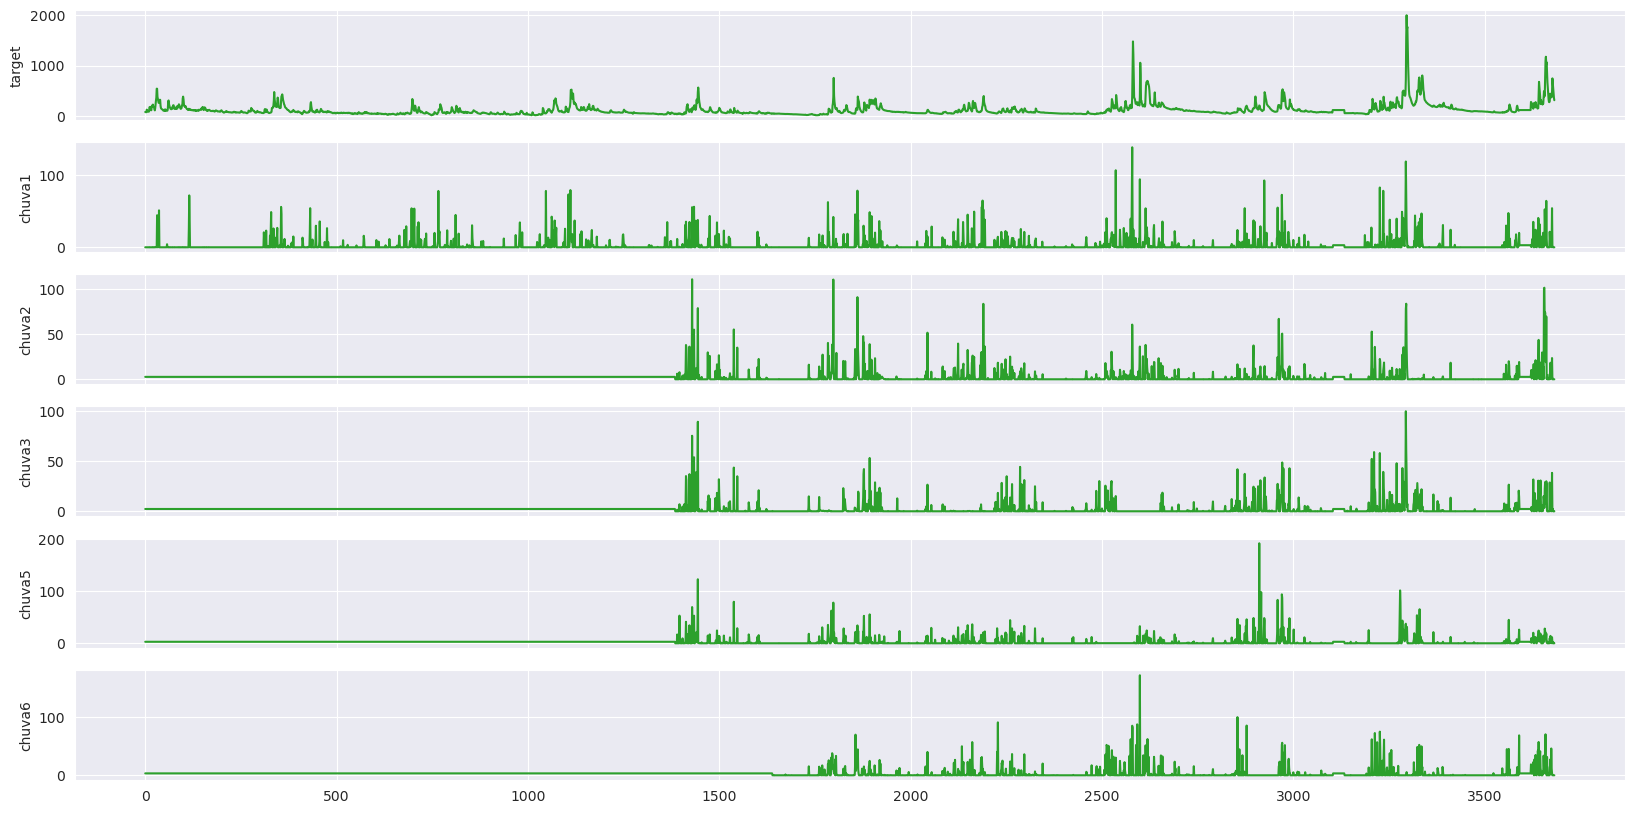

In [77]:
fig, vazoes = plt.subplots(6)
vazoes[0].plot(ds_alto.df.index, ds_alto.df['y'])
vazoes[0].set(ylabel='target')

vazoes[1].plot(ds_alto.df.index, ds_alto.df['vazao1'])
vazoes[1].set(ylabel='vazao1')

vazoes[2].plot(ds_alto.df.index, ds_alto.df['vazao2'])
vazoes[2].set(ylabel='vazao2')

vazoes[3].plot(ds_alto.df.index, ds_alto.df['vazao3'])
vazoes[3].set(ylabel='vazao3')

vazoes[4].plot(ds_alto.df.index, ds_alto.df['vazao5'])
vazoes[4].set(ylabel='vazao5')

vazoes[5].plot(ds_alto.df.index, ds_alto.df['vazao6'])
vazoes[5].set(ylabel='vazao6')

for ax in vazoes.flat:
    ax.label_outer()

#########

fig, chuvas = plt.subplots(6)
chuvas[0].plot(ds_alto.df.index, ds_alto.df['y'], 'tab:green')
chuvas[0].set(ylabel='target')

chuvas[1].plot(ds_alto.df.index, ds_alto.df['chuva1'], 'tab:green')
chuvas[1].set(ylabel='chuva1')

chuvas[2].plot(ds_alto.df.index, ds_alto.df['chuva2'], 'tab:green')
chuvas[2].set(ylabel='chuva2')

chuvas[3].plot(ds_alto.df.index, ds_alto.df['chuva3'], 'tab:green')
chuvas[3].set(ylabel='chuva3')

chuvas[4].plot(ds_alto.df.index, ds_alto.df['chuva5'], 'tab:green')
chuvas[4].set(ylabel='chuva5')

chuvas[5].plot(ds_alto.df.index, ds_alto.df['chuva6'], 'tab:green')
chuvas[5].set(ylabel='chuva6')

for ax in chuvas.flat:
    ax.label_outer()

### Formatando os dados para o Aprendizado Supervisionado

In [78]:
# # Parâmetros para gerar um objeto TimeSeriesStructure

# T = 5 # usará X lag(s) anterior(es)
# HORIZON = 1 # vai prever Y dia(s) à frente
# N_FEATURES = ds_alto.df.columns.size # As features são todas as colunas do dataset com os dados de todas as estações juntos

In [79]:
# data_structure = {'X' : (range(-T+1, 1), ds_alto.df.columns.values)}
# data_structure

In [80]:
# ds_alto.ml_inputs = TimeSeriesStructure(ds_alto.df, 'y', HORIZON, tensor_structure=data_structure, freq='D')

# ds_alto.X = ds_alto.ml_inputs.dataframe['X']
# ds_alto.y = ds_alto.ml_inputs.dataframe['target']

# ds_alto.ml_inputs.dataframe

In [81]:
# # Separando em TREINO e VALIDAÇÃO
# ds_alto.ml_train, ds_alto.ml_validation = ds_alto.split_train_test(ds_alto.ml_inputs.dataframe, 0.8)

# ds_alto.X_train = ds_alto.ml_train['X']
# ds_alto.y_train = ds_alto.ml_train['target']

# ds_alto.X_validation = ds_alto.ml_validation['X']
# ds_alto.y_validation = ds_alto.ml_validation['target']

# # ds_alto.X_train.shape, ds_alto.y_train.shape, ds_alto.X_validation.shape, ds_alto.y_validation.shape

##### Fazendo scaling dos dados de entrada

Os resultados estão muito distantes. O XGboost está tendo um resultado absurdamente bom enquanto que a rede LSTM está completamente perdida.
Vou tentar escalar os dados de entrada e comparar. É sabido que redes LSTM não se comportam bem com dados em escalas grandes e díspares, como neste caso, em que a chuva, em mm, tem valores minúsculos, e vazão em $m^3$/s.

A expectativa é que se comporte melhor.

#### XGBoost

XGBoost Vanilla, sem nenhuma otimização

In [82]:
# v_model = XGBRegressor(colsample_bytree=0.44, max_depth=222, min_child_weight=0, subsample=0.33, tree_method="hist", device="cuda")
# v_model.fit(ds_alto.X_train, ds_alto.y_train)

# vanilla_xgb = pd.DataFrame(data=v_model.predict(ds_alto.X_validation), columns=['pred'])
# vanilla_xgb['obs'] = pd.DataFrame(data=ds_alto.y_validation.values)
# vanilla_xgb['ds'] = ds_alto.ml_validation.index

# vanilla_xgb.plot('ds', ['obs', 'pred'], label=['observado', 'previsão'])
# plt.title('Previsão com XGBoost Regression')
# plt.xlabel('')
# plt.ylabel('Vazão ($m^3/s$)')
# plt.legend()
# plt.show()

# smape(vanilla_xgb['obs'], vanilla_xgb['pred']), r2_score(vanilla_xgb['obs'], vanilla_xgb['pred']), np.sqrt(mean_squared_error(vanilla_xgb['obs'], vanilla_xgb['pred']))

In [83]:
# # Feature Selection

# plot_importance(v_model, height=0.3)
# plt.show()

#### Otimizar o modelo XGBRegressor

**Tree-specific hyperparameters control the construction and complexity of the decision trees:**

<u>max_depth</u>: maximum depth of a tree. Deeper trees can capture more complex patterns in the data, but may also lead to overfitting. <<range: [0,∞]>>

<u>min_child_weight</u>: minimum sum of instance weight (hessian) needed in a child. This can be used to control the complexity of the decision tree by preventing the creation of too small leaves. <<range: [0,∞]>>

<u>subsample</u>: percentage of rows used for each tree construction. Lowering this value can prevent overfitting by training on a smaller subset of the data. <<range: (0,1]>>

<u>colsample_bytree</u>: percentage of columns used for each tree construction. Lowering this value can prevent overfitting by training on a subset of the features. <<range: (0, 1]>>
<br/><br/><br/><br/>
**Learning task-specific hyperparameters control the overall behavior of the model and the learning process:**

<u>eta (also known as learning rate)</u>: step size shrinkage used in updates to prevent overfitting. Lower values make the model more robust by taking smaller steps. <<range: [0,1]>>

<u>gamma</u>: minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values increase the regularization. <<range: [0,∞]>>

<u>lambda</u>: L2 regularization term on weights. Higher values increase the regularization. <<range: [0,∞]>>

<u>alpha</u>: L1 regularization term on weights. Higher values increase the regularization. <<range: [0,∞]>>

In [84]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
# import scipy.stats as sts

In [85]:
#sts.randint.rvs(0, 5000, size=10)
#sts.uniform.rvs(0.001, 1.001, size=10)

In [86]:
# # Tree-specific hyperparameters control the construction and complexity of the decision trees

# # params = {
# #     'max_depth' : [0,833,1666,2500,3333,4166,5000],
# #     'min_child_weight' : [0,833,1666,2500,3333,4166,5000],
# #     'subsample' : [0.001,0.1675,0.334,0.5005,0.667,0.8335,1],
# #     'colsample_bytree' : [0.001,0.1675,0.334,0.5005,0.667,0.8335,1],
# #     'learning_rate' : [1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 1e-0],
# #     'gamma' : [0,833,1666,2500,3333,4166,5000],
# #     'reg_lambda' : [0,833,1666,2500,3333,4166,5000],
# #     'alpha' : [0,833,1666,2500,3333,4166,5000],
# #     'max_bin' : [16,98,181,264,346,429,512]
# # }

# params = {
#     # 'max_depth' : sts.randint(0, 10),
#     # 'min_child_weight' : sts.randint(0, 10000),
#     # 'subsample' : sts.uniform(0.001, 1),
#     # 'colsample_bytree' : sts.uniform(0.001, 1),
#     'learning_rate' : sts.uniform(0.001, 1),
#     'gamma' : sts.randint(0, 10000),
#     'reg_lambda' : sts.randint(0, 10000),
#     'alpha' : sts.randint(0, 10000),

#     'max_bin' : sts.randint(0, 500)
# }

# t_model = XGBRegressor(tree_method="hist", device="cuda")

# cv = TimeSeriesSplit(n_splits=7)

# # tree_grid_search = GridSearchCV(t_model, param_grid=params, cv=cv, scoring='neg_mean_squared_error', n_jobs=3)
# # tree_grid_search.fit(ds_alto.X_train, ds_alto.y_train)
# # tree_xgb = pd.DataFrame(data=tree_grid_search.predict(ds_alto.X_validation), columns=['pred'])

# rand_search = RandomizedSearchCV(t_model, param_distributions=params, n_iter=1500, cv=cv, scoring='neg_mean_absolute_error', n_jobs=3)
# rand_search.fit(ds_alto.X_train, ds_alto.y_train)

# tree_xgb = pd.DataFrame(data=rand_search.predict(ds_alto.X_validation), columns=['pred'])
# tree_xgb['obs'] = pd.DataFrame(data=ds_alto.y_validation.values)
# tree_xgb['ds'] = ds_alto.ml_validation.index

# tree_xgb.plot('ds', ['obs', 'pred'], label=['observado', 'previsão'])
# plt.title('Previsão com XGBoost Regression')
# plt.xlabel('')
# plt.ylabel('Vazão ($m^3/s$)')
# plt.legend()
# plt.show()

# smape(tree_xgb['obs'], tree_xgb['pred']), r2_score(tree_xgb['obs'], tree_xgb['pred']), np.sqrt(mean_squared_error(tree_xgb['obs'], tree_xgb['pred']))

In [87]:
# print("Melhor conjunto de hiperparâmetros: ", tree_grid_search.best_params_)
# print("Best score: ", tree_grid_search.best_score_)

# print("Melhor conjunto de hiperparâmetros: ", rand_search.best_params_)
# print("Best score: ", rand_search.best_score_)

In [88]:
# Feature Selection

# plot_importance(rand_search.best_estimator_, height=0.3)
# plt.show()

In [89]:
# Learning task-specific hyperparameters control the overall behavior of the model and the learning process

# grid_params = {
#     'learning_rate' : [1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 1e-0],
#     'gamma' : [0,833,1666,2500,3333,4166,5000],
#     'reg_lambda' : [0,833,1666,2500,3333,4166,5000],
#     'alpha' : [0,833,1666,2500,3333,4166,5000]
# }

# l_model = XGBRegressor(tree_method="hist", device="cuda")

# cv = TimeSeriesSplit(n_splits=7)

# learning_grid_search = GridSearchCV(l_model, param_grid=grid_params, cv=cv, scoring='neg_mean_squared_error', n_jobs=3)
# learning_grid_search.fit(ds_alto.X_train, ds_alto.y_train)

# learning_xgb = pd.DataFrame(data=learning_grid_search.predict(ds_alto.X_validation), columns=['pred'])
# learning_xgb['obs'] = pd.DataFrame(data=ds_alto.y_validation.values)
# learning_xgb['ds'] = ds_alto.ml_validation.index

# learning_xgb.plot('ds', ['obs', 'pred'], label=['observado', 'previsão'])
# plt.title('Previsão com XGBoost Regression')
# plt.xlabel('')
# plt.ylabel('Vazão ($m^3/s$)')
# plt.legend()
# plt.show()

# smape(learning_xgb['obs'], learning_xgb['pred']), r2_score(learning_xgb['obs'], learning_xgb['pred']), np.sqrt(mean_squared_error(learning_xgb['obs'], learning_xgb['pred']))

In [90]:
# print("Melhor conjunto de hiperparâmetros: ", learning_grid_search.best_params_)
# print("Best score: ", learning_grid_search.best_score_)

In [91]:
# Feature Selection

# plot_importance(learning_grid_search.best_estimator_, height=0.3)
# plt.show()

### Nixtla

In [93]:
ds_alto.df

,ds,y,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva5,vazao5,chuva6,vazao6,unique_id
0,2013-01-01,82.787,0.0,49.475000,2.66756,71.762139,2.295398,28.032810,2.87748,115.548849,3.277873,60.056000,1
1,2013-01-02,80.489,0.0,46.957143,2.66756,71.762139,2.295398,28.032810,2.87748,115.548849,3.277873,37.546000,1
2,2013-01-03,78.214,0.0,46.721875,2.66756,71.762139,2.295398,28.032810,2.87748,115.548849,3.277873,39.228000,1
3,2013-01-04,79.349,0.0,49.183333,2.66756,71.762139,2.295398,28.032810,2.87748,115.548849,3.277873,37.546000,1
4,2013-01-05,129.161,0.0,49.780208,2.66756,71.762139,2.295398,28.032810,2.87748,115.548849,3.277873,39.228000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,2023-01-27,648.940,0.8,388.402708,0.80000,369.873333,2.400000,120.202917,0.00000,565.199583,0.200000,61.976891,1
3679,2023-01-28,520.591,0.0,263.569896,0.00000,244.310833,0.000000,111.370833,2.60000,387.516250,0.000000,61.976891,1
3680,2023-01-29,424.853,0.0,242.208229,0.00000,216.592083,0.000000,93.840417,0.00000,321.508333,0.000000,61.976891,1
3681,2023-01-30,362.965,0.0,227.691875,0.00000,206.661667,0.200000,81.679167,0.00000,299.070417,0.000000,61.976891,1


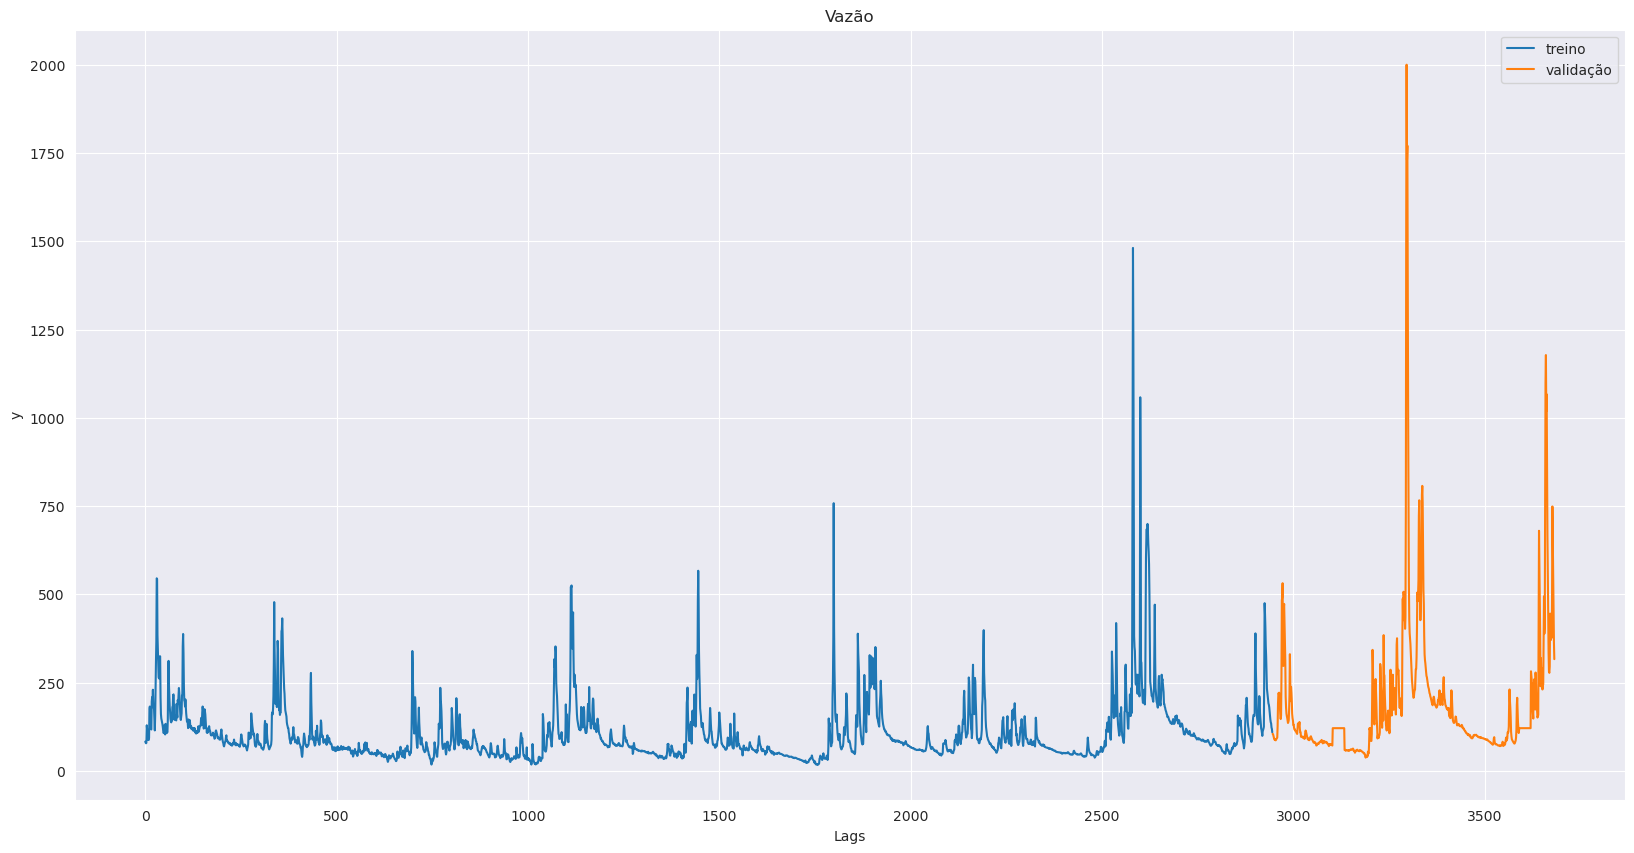

In [32]:
ds_alto.dl_train['y'].plot(label='treino')
ds_alto.dl_validation['y'].plot(label='validação')
plt.title('Vazão')
plt.xlabel('Lags')
plt.ylabel('y')
plt.legend()
plt.show()

#### MLForecast

In [1]:
import mlforecast as mlf
import lightgbm as lgb

# ds_alto.dl_validation

In [41]:
fcst = mlf.MLForecast(
    models=lgb.LGBMRegressor(),
    freq='D',
    lags=[5],
    num_threads=3
)

In [42]:
fcst.fit(ds_alto.dl_train, fitted=True, static_features=[])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1965
[LightGBM] [Info] Number of data points in the train set: 2941, number of used features: 11
[LightGBM] [Info] Start training from score 104.321985


MLForecast(models=[LGBMRegressor], freq=D, lag_features=['lag5'], date_features=[], num_threads=3)

In [43]:
futr_df = ds_alto.dl_validation[['ds', 'unique_id', 'chuva1', 'vazao1', 'chuva2', 'vazao2', 'chuva3', 'vazao3', 'chuva5', 'vazao5', 'chuva6', 'vazao6']]
futr_df

,ds,unique_id,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva5,vazao5,chuva6,vazao6
2946,2021-01-25,1.0,0.0,59.679167,0.0,35.587500,0.0,0.000000,0.0,98.458333,0.0,58.694000
2947,2021-01-26,1.0,0.0,58.070833,0.0,34.837500,0.0,0.000000,0.0,97.133333,0.0,54.380000
2948,2021-01-27,1.0,0.0,56.911458,0.0,33.150000,0.0,0.000000,0.2,91.685417,0.0,54.851000
2949,2021-01-28,1.0,0.0,54.156250,0.0,31.795833,0.0,0.000000,0.0,90.097917,0.0,52.062000
2950,2021-01-29,1.0,0.0,54.375000,0.0,31.104167,0.0,0.000000,0.0,88.810417,0.0,54.380000
...,...,...,...,...,...,...,...,...,...,...,...,...
3678,2023-01-27,1.0,0.8,388.402708,0.8,369.873333,2.4,120.202917,0.0,565.199583,0.2,61.976891
3679,2023-01-28,1.0,0.0,263.569896,0.0,244.310833,0.0,111.370833,2.6,387.516250,0.0,61.976891
3680,2023-01-29,1.0,0.0,242.208229,0.0,216.592083,0.0,93.840417,0.0,321.508333,0.0,61.976891
3681,2023-01-30,1.0,0.0,227.691875,0.0,206.661667,0.2,81.679167,0.0,299.070417,0.0,61.976891


In [44]:
preds = fcst.predict(h=fch, level=[90], X_df=futr_df)

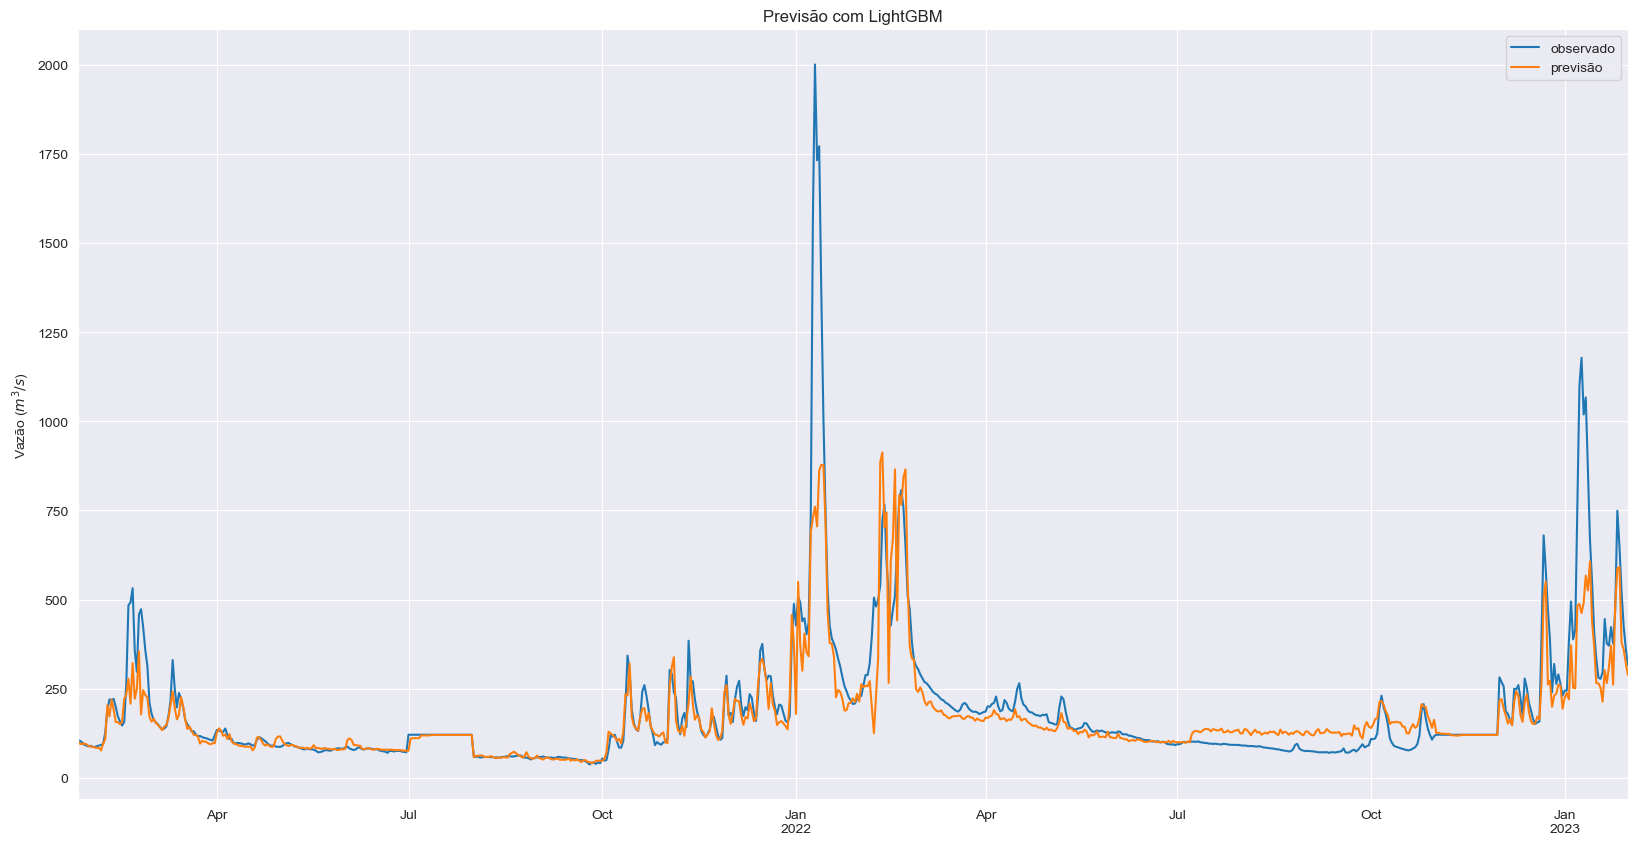

(0.17541767525125995, 0.7130986051823125, 105.6203325123756)

In [45]:
df_merged = pd.merge(left=ds_alto.dl_validation, right=preds, on='ds', how='left')
df_merged = df_merged[['ds', 'y', 'LGBMRegressor']]
df_merged.plot('ds', ['y', 'LGBMRegressor'], label=['observado', 'previsão'])

plt.title('Previsão com LightGBM')
plt.xlabel('')
plt.ylabel('Vazão ($m^3/s$)')
plt.legend()
plt.show()

smape(df_merged['y'], df_merged['LGBMRegressor']), r2_score(df_merged['y'], df_merged['LGBMRegressor']), np.sqrt(mean_squared_error(df_merged['y'], df_merged['LGBMRegressor']))

In [49]:
fcst.models['LGBMRegressor'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

#### Rede LSTM

Aplicação da biblioteca NeuralForecast

In [213]:
models = [
          LSTM(h=fch,                        # Forecast horizon // X dias
               max_steps=100,                # Number of steps to train (epochs)
               # loss=DistributionLoss(distribution='Normal', level=[80, 90]), # Usando a função de perda do DeepAR (famosa)
               loss=SMAPE(),
               scaler_type='robust',       # Type of scaler to normalize data
            #    hist_exog_list=['chuva1', 'vazao1', 'chuva2', 'vazao2', 'chuva3', 'vazao3', 'chuva4', 'vazao4', 'chuva5', 'vazao5', 'chuva6', 'vazao6'],
               futr_exog_list=['chuva1', 'vazao1', 'chuva2', 'vazao2', 'chuva3', 'vazao3', 'chuva4', 'vazao4', 'chuva5', 'vazao5', 'chuva6', 'vazao6'],
               encoder_hidden_size=64,      # Defines the size of the hidden state of the LSTM
               encoder_n_layers=1,
               decoder_hidden_size=64,      # Defines the number of hidden units of each layer of the MLP decoder
               decoder_layers=1,
               context_size=5,
               accelerator='gpu')               # usa os X dias anteriores para prever adiante.

      #     NHITS(h=fch,                       # Forecast horizon
      #           input_size=2 * len(df_test), # Length of input sequence
      #           max_steps=300,               # Number of steps to train
      #           n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output
          ]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=ds_alto.dl_train)

Global seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it, v_num=41, train_loss_step=0.323, train_loss_epoch=0.323]


In [26]:
futr_df = ds_alto.dl_validation[['ds', 'unique_id', 'chuva1', 'vazao1', 'chuva2', 'vazao2', 'chuva3', 'vazao3', 'chuva4', 'vazao4', 'chuva5', 'vazao5', 'chuva6', 'vazao6']]
futr_df

,ds,unique_id,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva4,vazao4,chuva5,vazao5,chuva6,vazao6
2946,2021-01-25,1.0,0.0,59.679167,0.0,35.587500,0.0,0.000000,0.0,254.035853,0.0,98.458333,0.0,58.694000
2947,2021-01-26,1.0,0.0,58.070833,0.0,34.837500,0.0,0.000000,0.0,254.035853,0.0,97.133333,0.0,54.380000
2948,2021-01-27,1.0,0.0,56.911458,0.0,33.150000,0.0,0.000000,0.0,254.035853,0.2,91.685417,0.0,54.851000
2949,2021-01-28,1.0,0.0,54.156250,0.0,31.795833,0.0,0.000000,0.0,254.035853,0.0,90.097917,0.0,52.062000
2950,2021-01-29,1.0,0.0,54.375000,0.0,31.104167,0.0,0.000000,0.0,254.035853,0.0,88.810417,0.0,54.380000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,2023-01-27,1.0,0.8,388.402708,0.8,369.873333,2.4,120.202917,0.0,311.915263,0.0,565.199583,0.2,61.976891
3679,2023-01-28,1.0,0.0,263.569896,0.0,244.310833,0.0,111.370833,0.0,243.242500,2.6,387.516250,0.0,61.976891
3680,2023-01-29,1.0,0.0,242.208229,0.0,216.592083,0.0,93.840417,0.0,190.820000,0.0,321.508333,0.0,61.976891
3681,2023-01-30,1.0,0.0,227.691875,0.0,206.661667,0.2,81.679167,0.0,228.868824,0.0,299.070417,0.0,61.976891


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


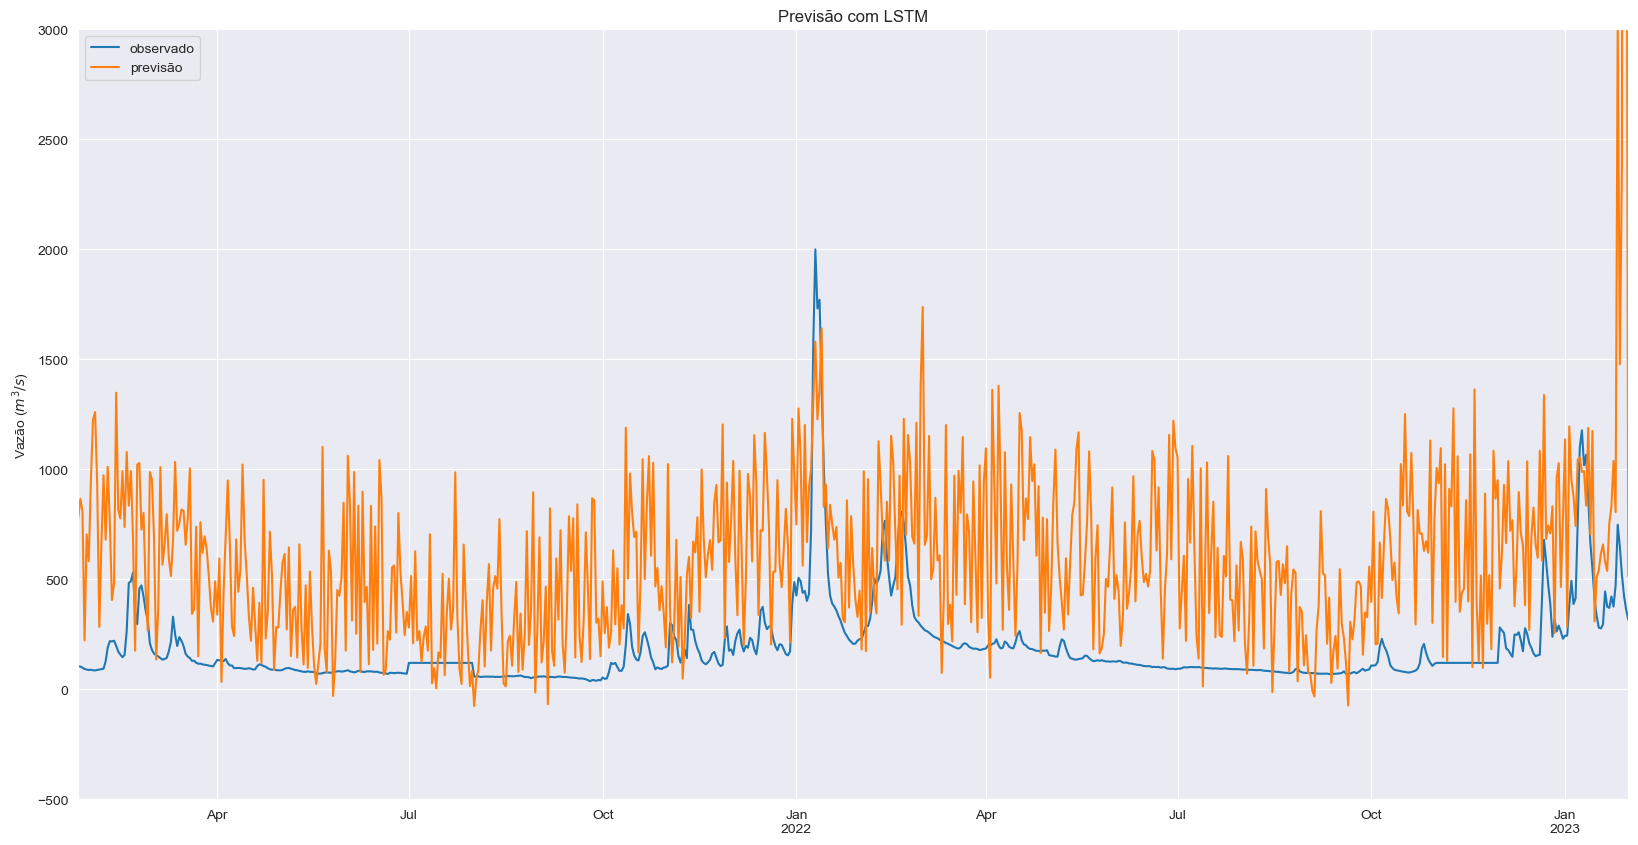

(1.0564329657117972, -11.196607041499336, 688.6534323223246)

In [217]:
neural_df = nf.predict(futr_df=futr_df)
# plot_df = pd.concat([ds_alto.dl_validation['y'], neural_df]).set_index('ds') # Concatenate the train and forecast dataframes
neural_df ['obs'] = ds_alto.dl_validation['y'].values

neural_df
# plot_df

# neural_df.plot('ds', ['obs', 'LSTM'], label=['observado', 'previsão'], ylim=[-500,3000])
# plt.title('Previsão com LSTM')
# plt.xlabel('')
# plt.ylabel('Vazão ($m^3/s$)')
# plt.legend()
# plt.show()

# smape(neural_df['obs'].values, neural_df['LSTM'].values), r2_score(neural_df['obs'], neural_df['LSTM']), np.sqrt(mean_squared_error(neural_df['obs'], neural_df['LSTM']))

In [25]:
# Testando o AutoLSTM para detecção dos melhores parâmetros

models_auto = [AutoLSTM(h=fch,
                        loss=SMAPE(),
                        gpus=1
                        num_samples=10)]

m_auto = NeuralForecast(models=models_auto, freq='D')

In [27]:
m_auto.fit(df=ds_alto.dl_train, val_size=7)

(_train_tune pid=14060) Global seed set to 12


Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.250, train_loss_epoch=1.250]        


2024-02-05 14:28:30,024	WARNING syncer.py:586 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/welson/ray_results/_train_tune_2024-02-05_14-23-19', which is outside base dir 'C:\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19'


Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.240, train_loss_epoch=1.240]        


2024-02-05 14:33:32,004	WARNING syncer.py:586 -- Last sync command failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/welson/ray_results/_train_tune_2024-02-05_14-23-19', which is outside base dir 'C:\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19'


Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.240, train_loss_epoch=1.240]        


2024-02-05 14:34:29,656	WARNING tune.py:192 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-02-05 14:34:29,661	WARNING tune.py:1122 -- Trial Runner checkpointing failed: Sync process failed: GetFileInfo() yielded path 'C:/Users/welson/ray_results/_train_tune_2024-02-05_14-23-19', which is outside base dir 'C:\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19'


Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.240, train_loss_epoch=1.240]        


2024-02-05 14:34:39,777	WARNING tune.py:1163 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="c://\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19", trainable=...)
2024-02-05 14:34:39,801	WARNING experiment_analysis.py:916 -- Failed to read the results for 10 trials:
- C:\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19\_train_tune_06843_00000_0_batch_size=16,context_size=10,decoder_hidden_size=256,encoder_hidden_size=200,encoder_n_layers=2,inferen_2024-02-05_14-23-27
- C:\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19\_train_tune_06843_00001_1_batch_size=32,context_size=5,decoder_hidden_size=512,encoder_hidden_size=100,encoder_n_layers=3,inferenc_2024-02-05_14-23-27
- C:\Users\welson\ray_results\_train_tune_2024-02-05_14-23-19\_train_tune_06843_00002_2_batch_size=16,context_size=50,decoder_hidden_size=256,encoder_hidden_size=200,encoder_n_layers=1,inferen_2024-02-05_14-23-27
- C:\Users\welso

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

# Médio Doce